**Imports**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
# from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from datetime import datetime

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

from keras.layers import Input, Conv2D 
from keras.layers import MaxPool2D, Flatten, Dense 
from keras import Model

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

**Data Preprocessing**

In [2]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


# Resize the images to 48x48x1
resized_train_images = np.zeros((train_images.shape[0], 48, 48, 1))
resized_test_images = np.zeros((test_images.shape[0], 48, 48, 1))

for i in range(train_images.shape[0]):
    resized_train_images[i] = cv2.resize(train_images[i], (48, 48)).reshape(48, 48, 1)

for i in range(test_images.shape[0]):
    resized_test_images[i] = cv2.resize(test_images[i], (48, 48)).reshape(48, 48, 1)

# Normalize the pixel values to [0, 1]
resized_train_images = resized_train_images / 255.0
resized_test_images = resized_test_images / 255.0

X_t = resized_train_images
Y_t = train_labels
X_test = resized_test_images
Y_test = test_labels

Y_t = keras.utils.to_categorical(Y_t)
Y_test = keras.utils.to_categorical(Y_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_t, Y_t, test_size=0.16666, random_state=42)

print("X_train shape:", X_train.shape) #(0.66*60,000)*28*28
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape) #(0.66*60,000)*28*28
print("Y_val shape:", Y_val.shape)
print("X_test  shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


11490434/11490434 [==============================] - 0s 0us/step
X_train shape: (50000, 48, 48, 1)
Y_train shape: (50000, 10)
X_val shape: (10000, 48, 48, 1)
Y_val shape: (10000, 10)
X_test  shape: (10000, 48, 48, 1)
Y_test shape: (10000, 10)


**VGG-16 Implementation**

In [3]:
def create_model(act): #'relu', 'sigmoid', 'tanh', tf.keras.layers.LeakyReLU(alpha=0.1)
  input = Input(shape =(48,48,1))

  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act)(input)
  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation=act)(x)
  x = MaxPool2D(pool_size =2, strides =2)(x)

  x = Flatten()(x)
  x = Dense(units = 4096, activation =act)(x)
  x = Dense(units = 4096, activation =act)(x)
  output = Dense(units = 10, activation ='softmax')(x)
  model = Model (inputs=input, outputs =output)

  return model

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

In [4]:
# tf.keras.utils.plot_model( 
#     model,
#     show_shapes=True,
#     show_layer_names=True, 
# )

create_model('relu').summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       147584    
                                                             

**Optimizers**

In [5]:
def adam_opt(model,l_rate):
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=l_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def rms_prop(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=l_rate,
      rho=0.9,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model
  
def momentum_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.9,
      nesterov=False) #################
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def vanilla_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.0)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model


In [6]:
def eval(model):
  _, train_acc = model.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = model.evaluate(X_val, Y_val, verbose=0)
  _, test_acc = model.evaluate(X_test, Y_test, verbose=0)

  print('Training  Accuracy:   %.3f' % train_acc)
  print('Validation Accuracy:  %.3f' % val_acc)
  print('Testing Accuracy:     %.3f' % test_acc)

**a) What is best activation function?**

In [7]:
train_accu = []
val_accu = []
test_accu = []
h = []
act = ["relu","sigmoid","tanh",tf.keras.layers.LeakyReLU(alpha=0.1)]


def train_act(EPOCHS=50,BATCH_SIZE = 128):
  # %load_ext tensorboard
  # log_dir = "logs1a/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  # tensorboard_callback = TensorBoard(log_dir=log_dir)

  for index in range(4):
    model = create_model(act[index])
    model = adam_opt(model,0.0001)

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=128,epochs=50,verbose=1,shuffle=True,callbacks=[history])
    h.append(history)

    # %tensorboard --logdir logs1a/scalars
    _, train_acc = model.evaluate(X_train, Y_train, verbose=0)
    _, val_acc = model.evaluate(X_val, Y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # print('Training  Accuracy:   %.3f' % train_acc)
    # print('Validation Accuracy:  %.3f' % val_acc)
    # print('Testing Accuracy:     %.3f' % test_acc)
    train_accu.append(train_acc)
    val_accu.append(val_acc)
    test_accu.append(test_acc)

     

In [8]:
train_act()

Epoch 1/50
391/391 [==============================] - 39s 70ms/step - loss: 0.3857 - accuracy: 0.8668 - val_loss: 0.0645 - val_accuracy: 0.9807
Epoch 2/50
391/391 [==============================] - 25s 64ms/step - loss: 0.0652 - accuracy: 0.9799 - val_loss: 0.0588 - val_accuracy: 0.9825
Epoch 3/50
391/391 [==============================] - 25s 64ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.0437 - val_accuracy: 0.9879
Epoch 4/50
391/391 [==============================] - 25s 64ms/step - loss: 0.0323 - accuracy: 0.9903 - val_loss: 0.0422 - val_accuracy: 0.9884
Epoch 5/50
391/391 [==============================] - 26s 67ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.0544 - val_accuracy: 0.9858
Epoch 6/50
391/391 [==============================] - 25s 64ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0449 - val_accuracy: 0.9883
Epoch 7/50
391/391 [==============================] - 26s 67ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0510 - val_accuracy:

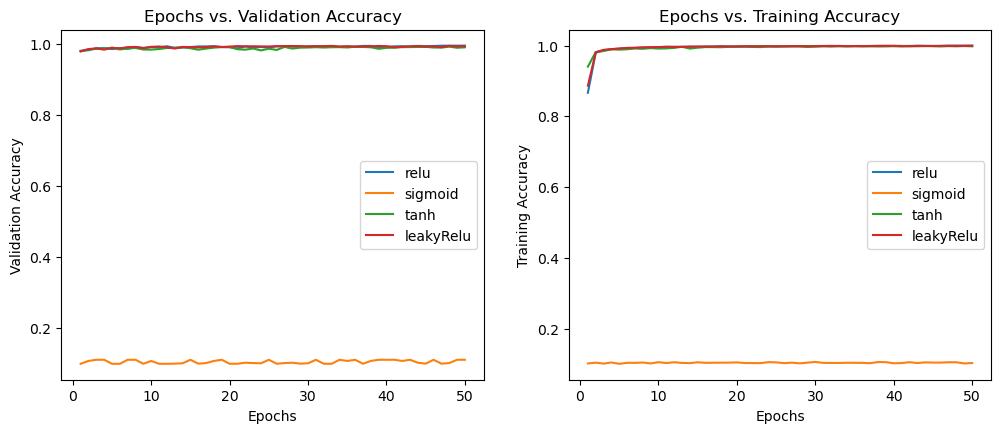

In [9]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
act1 = ["relu","sigmoid","tanh","leakyRelu"]

for i in range(4):
    ax1.plot(np.arange(1,50+1), h[i].val_acc)
    ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
        title='Epochs vs. Validation Accuracy')
    ax1.legend(act1)
    ax2.plot(np.arange(1,50+1), h[i].acc)
    ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
        title='Epochs vs. Training Accuracy')
    ax2.legend(act1)

plt.show()

In [10]:
train_accu1 = []
val_accu1 = []
test_accu1 = []
h1 = []


def train_act1(EPOCHS=50,BATCH_SIZE = 128):
  # %load_ext tensorboard
  # log_dir = "logs1a/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  # tensorboard_callback = TensorBoard(log_dir=log_dir)

  for index in range(4):
    model = create_model("tanh")
    if(index==0):
        model = adam_opt(model,0.0001)
    elif(index==1):
        model = momentum_gd(model,0.01)
    elif(index==2):
        model = vanilla_gd(model,0.01)
    else:
        model = rms_prop(model,0.0001)
    

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=128,epochs=50,verbose=1,shuffle=True,callbacks=[history])
    h1.append(history)

    # %tensorboard --logdir logs1a/scalars
    _, train_acc = model.evaluate(X_train, Y_train, verbose=0)
    _, val_acc = model.evaluate(X_val, Y_val, verbose=0)
    _, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # print('Training  Accuracy:   %.3f' % train_acc)
    # print('Validation Accuracy:  %.3f' % val_acc)
    # print('Testing Accuracy:     %.3f' % test_acc)
    train_accu1.append(train_acc)
    val_accu1.append(val_acc)
    test_accu1.append(test_acc)

train_act1()


Epoch 1/50
391/391 [==============================] - 31s 68ms/step - loss: 0.1953 - accuracy: 0.9368 - val_loss: 0.0851 - val_accuracy: 0.9741
Epoch 2/50
391/391 [==============================] - 27s 69ms/step - loss: 0.0663 - accuracy: 0.9797 - val_loss: 0.0545 - val_accuracy: 0.9846
Epoch 3/50
391/391 [==============================] - 27s 68ms/step - loss: 0.0448 - accuracy: 0.9861 - val_loss: 0.0495 - val_accuracy: 0.9875
Epoch 4/50
391/391 [==============================] - 26s 66ms/step - loss: 0.0431 - accuracy: 0.9874 - val_loss: 0.0669 - val_accuracy: 0.9829
Epoch 5/50
391/391 [==============================] - 27s 69ms/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.0438 - val_accuracy: 0.9868
Epoch 6/50
391/391 [==============================] - 26s 66ms/step - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.0548 - val_accuracy: 0.9857
Epoch 7/50
391/391 [==============================] - 26s 66ms/step - loss: 0.0347 - accuracy: 0.9894 - val_loss: 0.0535 - val_accuracy:

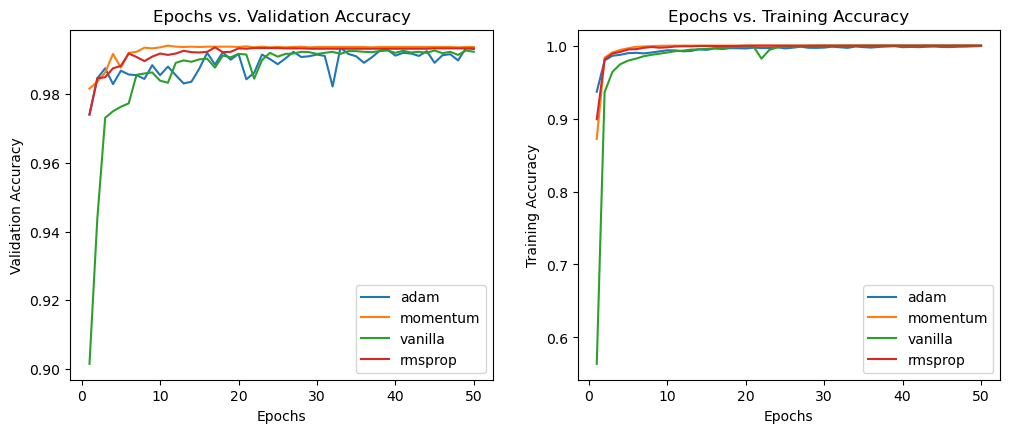

In [11]:
fig1 = plt.figure(figsize = (12,10))
ax1 = fig1.add_subplot(2,2,1)
ax2 = fig1.add_subplot(2,2,2)
opt = ["adam","momentum","vanilla","rmsprop"]

for i in range(4):
    ax1.plot(np.arange(1,50+1), h1[i].val_acc)
    ax1.set(xlabel='Epochs', ylabel='Validation Accuracy',
        title='Epochs vs. Validation Accuracy')
    ax1.legend(opt)
    ax2.plot(np.arange(1,50+1), h1[i].acc)
    ax2.set(xlabel='Epochs', ylabel='Training Accuracy',
        title='Epochs vs. Training Accuracy')
    ax2.legend(opt)

plt.show()